<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/7.modern_convolutional_neural_networks/7_3_network_in_network_nin_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [2]:
def nin_block(num_channels, kernel_size, strides, padding):

  return tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(num_channels, kernel_size, strides=strides,
                             padding=padding, activation='relu'),
      tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                               activation='relu'),
      tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                               activation='relu')
  ])

In [3]:
def net():

  return tf.keras.models.Sequential([
    nin_block(96, kernel_size=11, strides=4, padding='valid'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
    nin_block(256, kernel_size=5, strides=1, padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
    nin_block(384, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
    tf.keras.layers.Dropout(0.5),
    nin_block(10, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Reshape((1, 1, 10)),
    tf.keras.layers.Flatten(),
  ])

In [4]:
X = tf.random.uniform((1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Sequential output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Sequential output shape:	 (1, 12, 12, 384)
MaxPooling2D output shape:	 (1, 5, 5, 384)
Dropout output shape:	 (1, 5, 5, 384)
Sequential output shape:	 (1, 5, 5, 10)
GlobalAveragePooling2D output shape:	 (1, 10)
Reshape output shape:	 (1, 1, 1, 10)
Flatten output shape:	 (1, 10)


In [5]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn))

In [6]:
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
  device_name = device._device_name
  strategy = tf.distribute.OneDeviceStrategy(device_name)
  with strategy.scope():
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    net = net_fn()
    net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[PlotLossesKeras()])
  return net

In [7]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if len(tf.config.experimental.list_physical_devices('GPU')) >= i + 1:
        return tf.device(f'/GPU:{i}')
    return tf.device('/CPU:0')

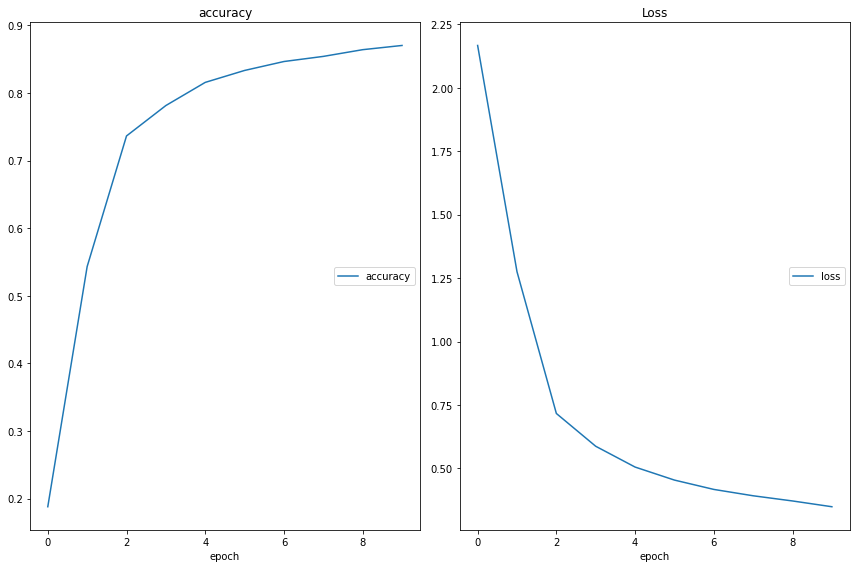

accuracy
	accuracy         	 (min:    0.188, max:    0.870, cur:    0.870)
Loss
	loss             	 (min:    0.349, max:    2.167, cur:    0.349)


In [8]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())